<a href="https://colab.research.google.com/github/BrunoAFurquim/Sugarcane-Disease-Classification/blob/Exploratory-Analysis/sugarcane_disease_exploratory_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python matplotlib numpy

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns
import os
from google.colab import files

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Dried Leaves.zip to Dried Leaves.zip
Saving Healthy Leaves.zip to Healthy Leaves.zip
Saving Sett Rot.zip to Sett Rot.zip
Saving Viral Disease.zip to Viral Disease.zip


In [46]:
from collections import defaultdict

class_zips = {
    'dried': 'Dried Leaves.zip',
    'healthy': 'Healthy Leaves.zip',
    'sett_rot': 'Sett Rot.zip',
    'viral_disease': 'Viral Disease.zip'
}

class_stats = defaultdict(lambda: {
    'heights': [],
    'widths': [],
    'means_rgb': [],       # Lista de arrays [R_mean, G_mean, B_mean] por imagem
    'stds_rgb': [],        # Lista de arrays [R_std, G_std, B_std] por imagem
    'correlation_rg': [],  # Correlação entre R e G
    'correlation_rb': [],  # Correlação entre R e B
    'correlation_gb': [],  # Correlação entre G e B
    'dominant_color': [],  # Canal dominante (R, G ou B)
    'image_paths': [],
    'unique_files': set()
})

Extraindo Zips e Coletando Estatísticas

In [47]:
for class_name, zip_file in class_zips.items():
    if not os.path.exists(zip_file):
        print(f"AVISO: Arquivo {zip_file} não encontrado. Pulando...")
        continue

    extract_path = f'/content/{class_name}'

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    for root, _, files in os.walk(extract_path):
        for file in files:
            if file.lower().endswith(('.apng', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)

                if file not in class_stats[class_name]['unique_files']:
                    img = cv2.imread(img_path)

                    if img is not None:
                        if len(img.shape) == 2:
                            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

                        h, w, _ = img.shape
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertendo para RGB

                        # Calculando médias e desvios por canal
                        mean, std = cv2.meanStdDev(img_rgb)
                        mean_rgb = mean.flatten()  # [R, G, B]
                        std_rgb = std.flatten()    # [R_std, G_std, B_std]

                        # Correlação entre canais
                        r_channel = img_rgb[:, :, 0].flatten()
                        g_channel = img_rgb[:, :, 1].flatten()
                        b_channel = img_rgb[:, :, 2].flatten()

                        corr_rg = np.corrcoef(r_channel, g_channel)[0, 1]
                        corr_rb = np.corrcoef(r_channel, b_channel)[0, 1]
                        corr_gb = np.corrcoef(g_channel, b_channel)[0, 1]

                        # Canal dominante (maior média)
                        dominant_channel = ['R', 'G', 'B'][np.argmax(mean_rgb)]

                        # Armazenando tudo
                        class_stats[class_name]['heights'].append(h)
                        class_stats[class_name]['widths'].append(w)
                        class_stats[class_name]['means_rgb'].append(mean_rgb)
                        class_stats[class_name]['stds_rgb'].append(std_rgb)
                        class_stats[class_name]['correlation_rg'].append(corr_rg)
                        class_stats[class_name]['correlation_rb'].append(corr_rb)
                        class_stats[class_name]['correlation_gb'].append(corr_gb)
                        class_stats[class_name]['dominant_color'].append(dominant_channel)
                        class_stats[class_name]['image_paths'].append(img_path)
                        class_stats[class_name]['unique_files'].add(file)

Função para mostrar estatísticas por classe

In [48]:
def print_class_stats(stats, class_name):
    data = stats[class_name]
    print(f"\n{'='*50}")
    print(f"Análise da classe: {class_name.upper()}")
    print(f"{'='*50}")
    print(f"Total de imagens: {len(data['unique_files'])}")
    print(f"Altura média: {np.mean(data['heights']):.2f} ± {np.std(data['heights']):.2f} px")
    print(f"Largura média: {np.mean(data['widths']):.2f} ± {np.std(data['widths']):.2f} px")

    if data['means_rgb']:
        means_rgb = np.array(data['means_rgb'])
        stds_rgb = np.array(data['stds_rgb'])

        print("\nMédia de cores por canal:")
        print(f"Red:   {np.mean(means_rgb[:,0]):.2f} ± {np.mean(stds_rgb[:,0]):.2f}")
        print(f"Green: {np.mean(means_rgb[:,1]):.2f} ± {np.mean(stds_rgb[:,1]):.2f}")
        print(f"Blue:  {np.mean(means_rgb[:,2]):.2f} ± {np.mean(stds_rgb[:,2]):.2f}")

        print("\nCorrelação entre canais:")
        print(f"R-G: {np.mean(data['correlation_rg']):.2f}")
        print(f"R-B: {np.mean(data['correlation_rb']):.2f}")
        print(f"G-B: {np.mean(data['correlation_gb']):.2f}")

        # Contagem de canal dominante
        dominant_counts = {
            'R': data['dominant_color'].count('R'),
            'G': data['dominant_color'].count('G'),
            'B': data['dominant_color'].count('B')
        }
        total = sum(dominant_counts.values())
        print("\nCanal dominante (%):")
        print(f"Red:   {dominant_counts['R']/total*100:.1f}%")
        print(f"Green: {dominant_counts['G']/total*100:.1f}%")
        print(f"Blue:  {dominant_counts['B']/total*100:.1f}%")

for class_name in class_zips.keys():
    if class_name in class_stats:
        print_class_stats(class_stats, class_name)


Análise da classe: DRIED
Total de imagens: 343
Altura média: 1024.00 ± 0.00 px
Largura média: 768.00 ± 0.00 px

Média de cores por canal:
Red:   166.78 ± 26.52
Green: 162.76 ± 28.13
Blue:  156.32 ± 30.24

Correlação entre canais:
R-G: 0.96
R-B: 0.88
G-B: 0.96

Canal dominante (%):
Red:   87.5%
Green: 0.3%
Blue:  12.2%

Análise da classe: HEALTHY
Total de imagens: 430
Altura média: 1008.37 ± 82.20 px
Largura média: 768.00 ± 0.00 px

Média de cores por canal:
Red:   99.66 ± 43.81
Green: 119.20 ± 47.32
Blue:  96.39 ± 49.43

Correlação entre canais:
R-G: 0.93
R-B: 0.96
G-B: 0.95

Canal dominante (%):
Red:   2.8%
Green: 95.8%
Blue:  1.4%

Análise da classe: SETT_ROT
Total de imagens: 652
Altura média: 1024.00 ± 0.00 px
Largura média: 768.00 ± 0.00 px

Média de cores por canal:
Red:   128.70 ± 48.02
Green: 119.97 ± 49.76
Blue:  113.28 ± 45.96

Correlação entre canais:
R-G: 0.98
R-B: 0.97
G-B: 0.98

Canal dominante (%):
Red:   100.0%
Green: 0.0%
Blue:  0.0%

Análise da classe: VIRAL_DISEASE


Bloxplot de dimensões

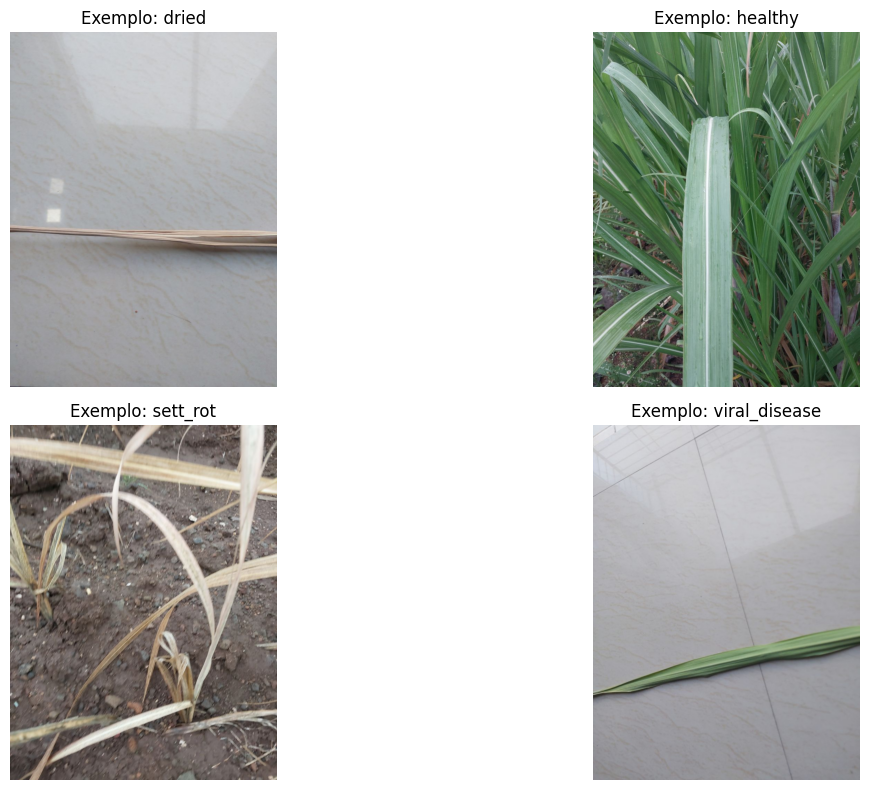

In [49]:
import plotly.express as px

plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_stats, 1):
    if not class_stats[class_name]['image_paths']:
        print(f"Warning: No images found for class {class_name}")
        continue

    img_path = class_stats[class_name]['image_paths'][0]

    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Failed to load {img_path}")
        continue

    channels = class_stats[class_name].get('channels',
                                         img.shape[2] if len(img.shape) == 3 else 1)

    plt.subplot(2, 2, i)
    if channels == 1:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    plt.title(f'Exemplo: {class_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [50]:
import plotly.express as px

counts = [len(class_stats[cls]['image_paths']) for cls in class_stats]
fig = px.pie(names=list(class_stats.keys()), values=counts, title='Distribuição de Classes')
fig.show()

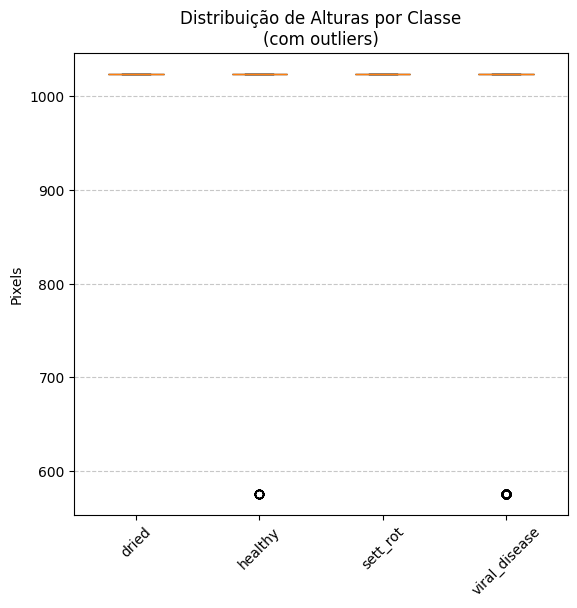

In [51]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
all_heights = [class_stats[cls]['heights'] for cls in class_stats]
bp = plt.boxplot(all_heights, tick_labels=list(class_stats.keys()), patch_artist=True)

colors = ['lightgreen', 'lightblue', 'salmon', 'gold']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Distribuição de Alturas por Classe\n(com outliers)', fontsize=12)
plt.ylabel('Pixels')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

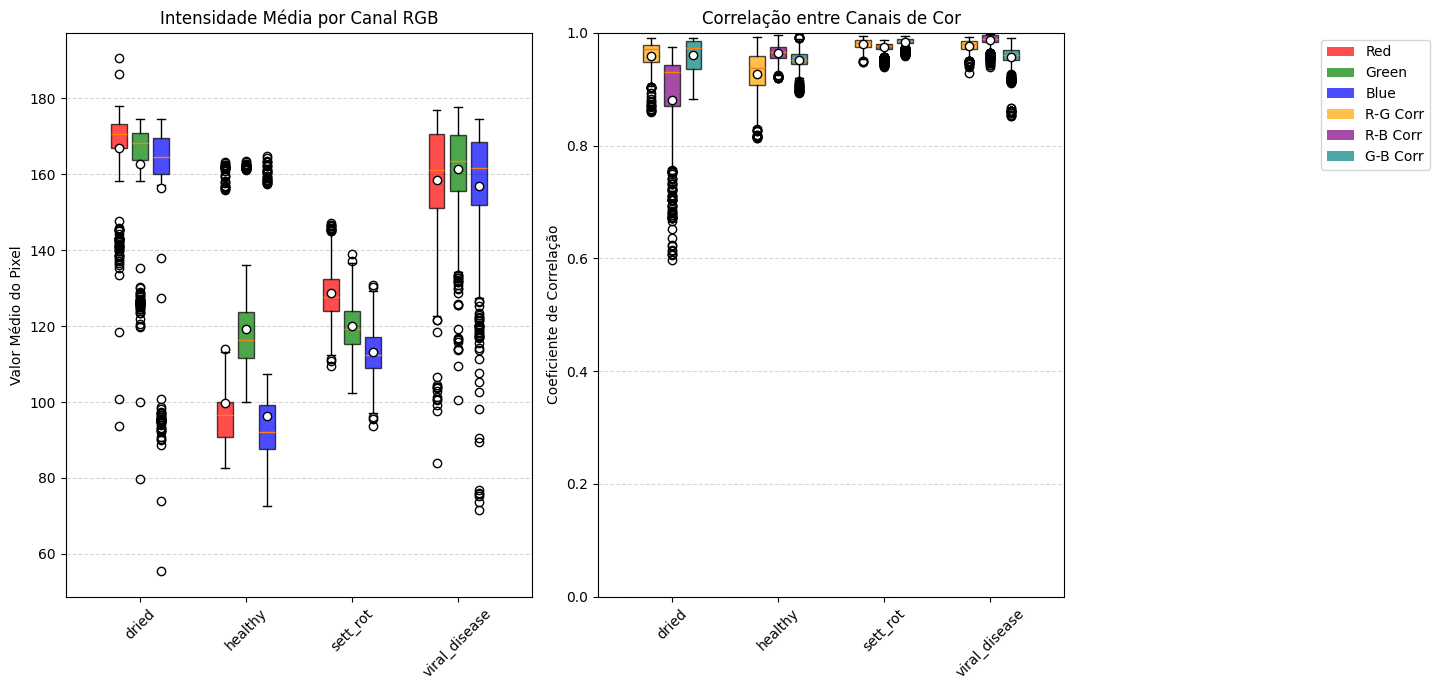

In [53]:
plt.figure(figsize=(15, 7))

intensities_rgb = {cls: {'R': [], 'G': [], 'B': []} for cls in class_stats}
correlations = {cls: {'R-G': [], 'R-B': [], 'G-B': []} for cls in class_stats}

for cls in class_stats:
    means_rgb = np.array(class_stats[cls]['means_rgb'])
    intensities_rgb[cls]['R'] = means_rgb[:, 0]
    intensities_rgb[cls]['G'] = means_rgb[:, 1]
    intensities_rgb[cls]['B'] = means_rgb[:, 2]

    correlations[cls]['R-G'] = class_stats[cls]['correlation_rg']
    correlations[cls]['R-B'] = class_stats[cls]['correlation_rb']
    correlations[cls]['G-B'] = class_stats[cls]['correlation_gb']

# Gráfico 1: Intensidade por canal
plt.subplot(1, 2, 1)
colors = ['red', 'green', 'blue']
box_width = 0.15
spacing = 0.2
class_positions = np.arange(len(class_stats))

for i, channel in enumerate(['R', 'G', 'B']):
    data = [intensities_rgb[cls][channel] for cls in class_stats]
    positions = class_positions + i * spacing

    bp = plt.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True,
                    showmeans=True,
                    meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'},
                    tick_labels=[cls if i == 1 else '' for cls in class_stats])

    for box in bp['boxes']:
        box.set_facecolor(colors[i])
        box.set_alpha(0.7)

plt.title('Intensidade Média por Canal RGB', fontsize=12)
plt.ylabel('Valor Médio do Pixel')
plt.xticks(class_positions + spacing, class_stats.keys(), rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Gráfico 2: Correlações entre canais
plt.subplot(1, 2, 2)
corr_colors = ['orange', 'purple', 'teal']
corr_labels = ['R-G', 'R-B', 'G-B']

for i, corr_type in enumerate(['R-G', 'R-B', 'G-B']):
    data = [correlations[cls][corr_type] for cls in class_stats]
    positions = class_positions + i * spacing

    bp = plt.boxplot(data, positions=positions, widths=box_width,
                    patch_artist=True,
                    showmeans=True,
                    meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black'},
                    tick_labels=[cls if i == 1 else '' for cls in class_stats])

    for box in bp['boxes']:
        box.set_facecolor(corr_colors[i])
        box.set_alpha(0.7)

plt.title('Correlação entre Canais de Cor', fontsize=12)
plt.ylabel('Coeficiente de Correlação')
plt.xticks(class_positions + spacing, class_stats.keys(), rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

legend_patches = [plt.Rectangle((0,0), 1, 1, fc=color, alpha=0.7)
                 for color in colors + corr_colors]
plt.legend(legend_patches, ['Red', 'Green', 'Blue', 'R-G Corr', 'R-B Corr', 'G-B Corr'],
           loc='upper right', bbox_to_anchor=(1.8, 1))

plt.tight_layout()
plt.show()

# Análises de Distribuição de Canais RGB

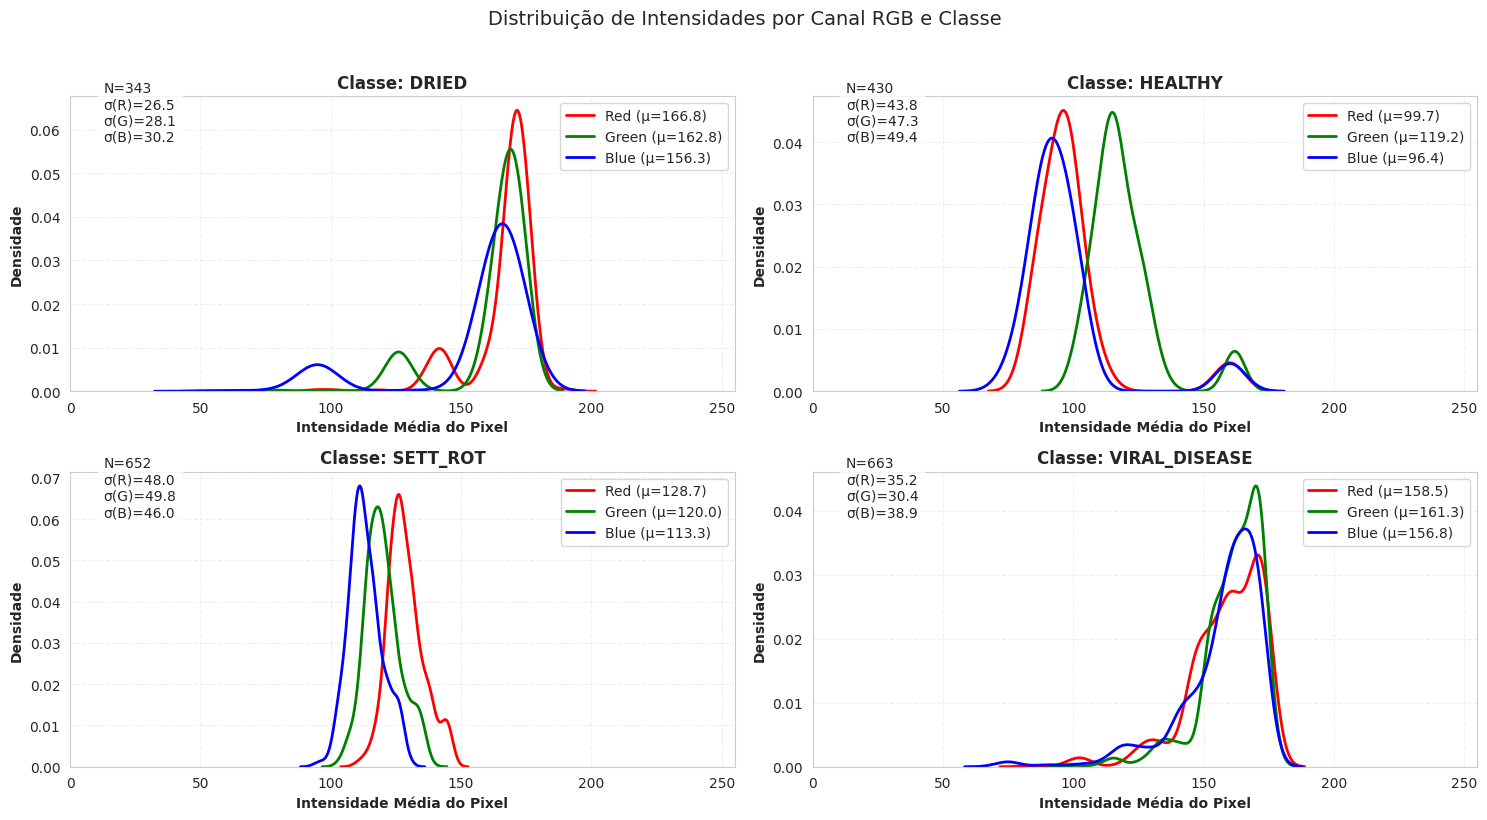

In [72]:
plt.figure(figsize=(15, 8))
plt.suptitle('Distribuição de Intensidades por Canal RGB e Classe', y=1.02, fontsize=14)

for i, cls in enumerate(class_stats.keys()):
    plt.subplot(2, 2, i+1)

    means_rgb = np.array(class_stats[cls]['means_rgb'])
    stds_rgb = np.array(class_stats[cls]['stds_rgb'])

    sns.kdeplot(means_rgb[:, 0], label=f'Red (μ={np.mean(means_rgb[:,0]):.1f})', color='r', linestyle='-', linewidth=2)
    sns.kdeplot(means_rgb[:, 1], label=f'Green (μ={np.mean(means_rgb[:,1]):.1f})', color='g', linestyle='-', linewidth=2)
    sns.kdeplot(means_rgb[:, 2], label=f'Blue (μ={np.mean(means_rgb[:,2]):.1f})', color='b', linestyle='-', linewidth=2)

    plt.text(0.05, 0.85,
             f'N={len(means_rgb)}\nσ(R)={np.mean(stds_rgb[:,0]):.1f}\nσ(G)={np.mean(stds_rgb[:,1]):.1f}\nσ(B)={np.mean(stds_rgb[:,2]):.1f}',
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8))

    plt.title(f'Classe: {cls.upper()}', fontweight='bold')
    plt.legend(loc='upper right')
    plt.xlabel('Intensidade Média do Pixel')
    plt.ylabel('Densidade')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.xlim(0, 255)

plt.tight_layout()
plt.show()

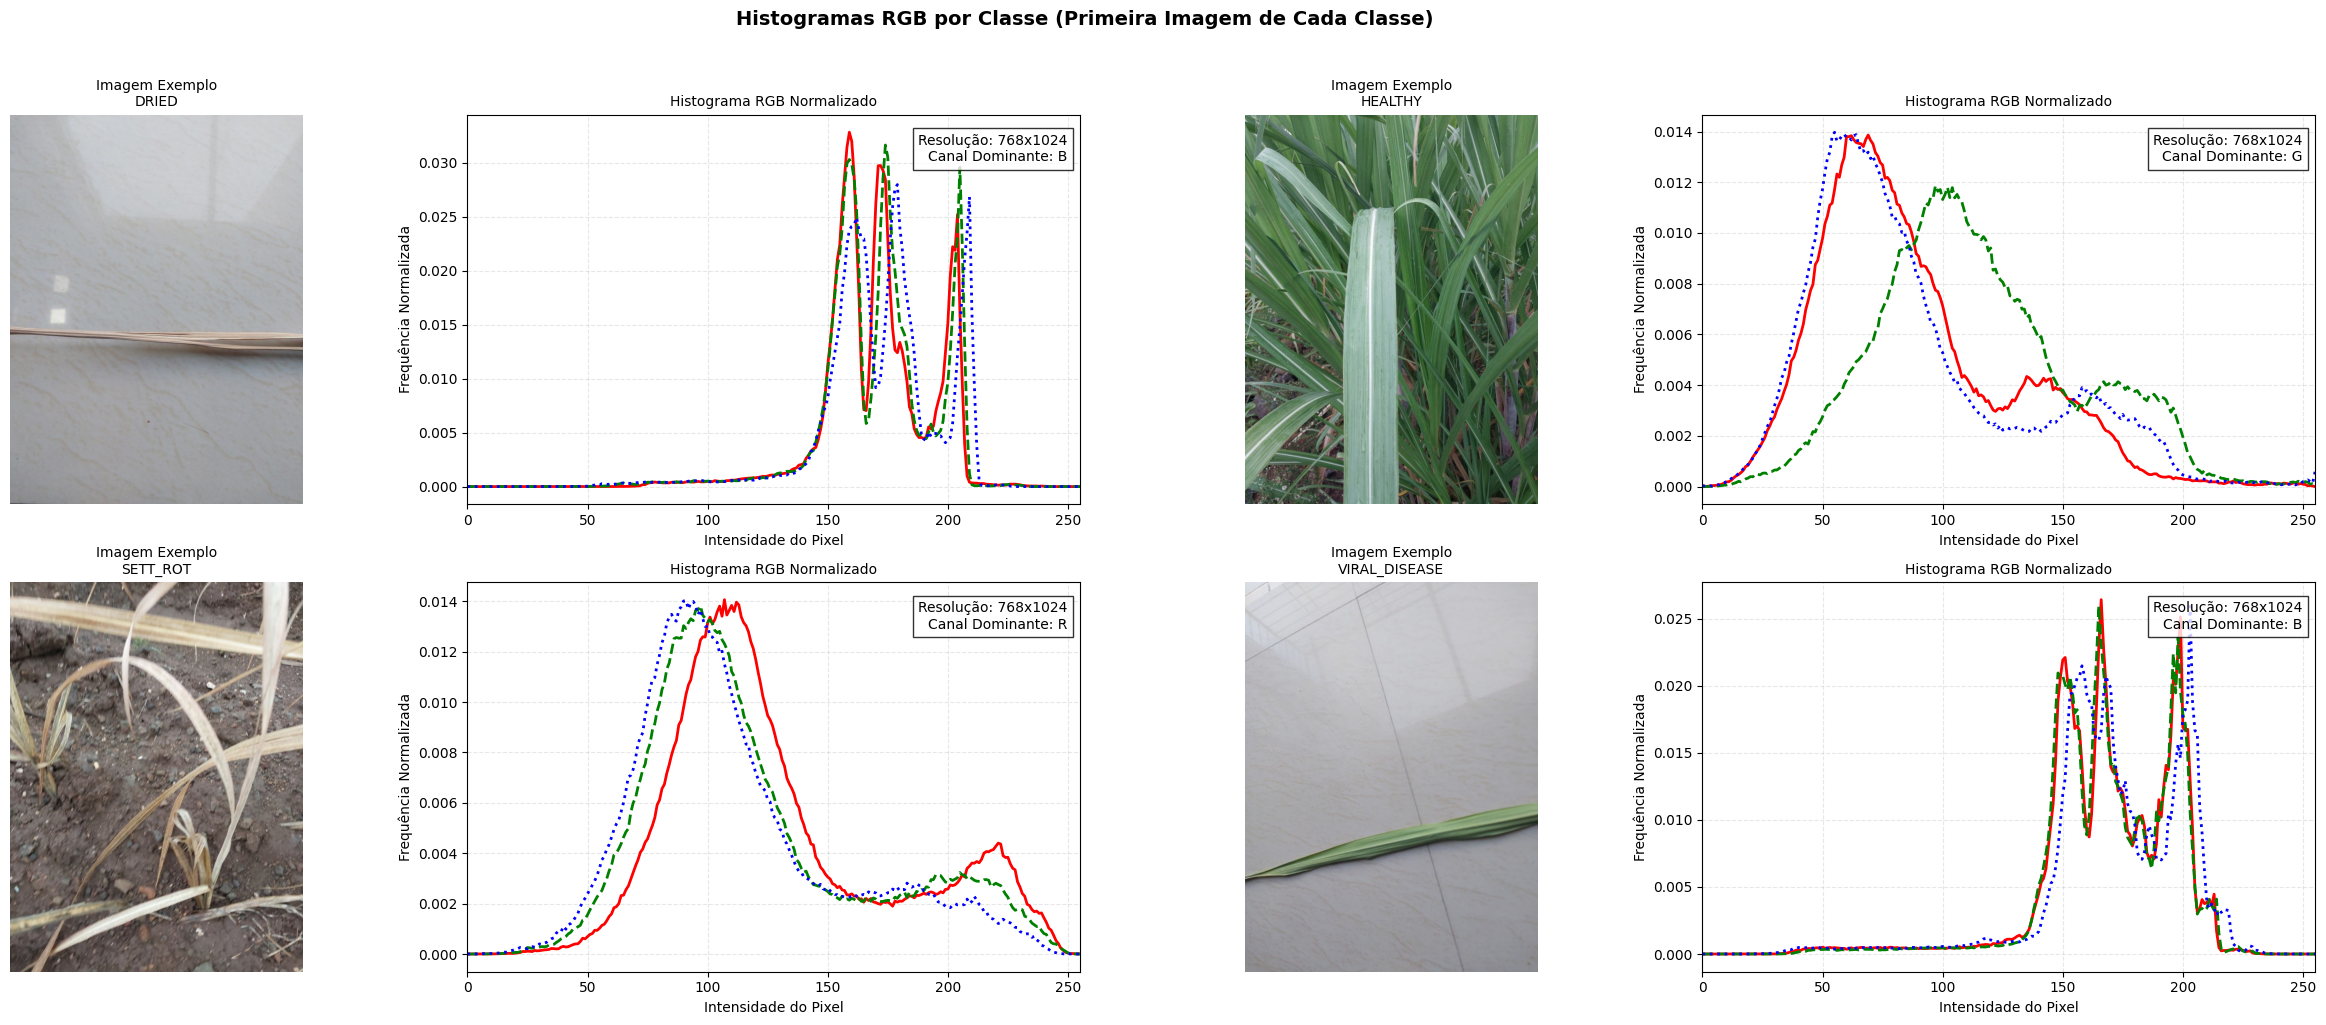

In [65]:
plt.figure(figsize=(25, 10))
plt.suptitle('Histogramas RGB por Classe (Primeira Imagem de Cada Classe)', y=1.02, fontsize=14, fontweight='bold')

for i, cls in enumerate(class_stats):
    # Carrega e converte a imagem
    img = cv2.imread(class_stats[cls]['image_paths'][0])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Cria subplot com imagem e histograma
    plt.subplot(2, 4, 2*i+1)
    plt.imshow(img_rgb)
    plt.title(f'Imagem Exemplo\n{cls.upper()}', fontsize=10)
    plt.axis('off')

    plt.subplot(2, 4, 2*i+2)
    colors = ['red', 'green', 'blue']
    channel_names = ['Red', 'Green', 'Blue']
    line_styles = ['-', '--', ':']

    for j, (color, name, ls) in enumerate(zip(colors, channel_names, line_styles)):
        hist = cv2.calcHist([img_rgb], [j], None, [256], [0, 256])
        # Normaliza o histograma
        hist = hist / hist.sum()
        plt.plot(hist, color=color, label=name, linestyle=ls, linewidth=2)

    img_height, img_width = img.shape[:2]
    plt.text(0.98, 0.95,
             f'Resolução: {img_width}x{img_height}\n'
             f'Canal Dominante: {class_stats[cls]["dominant_color"][0]}',
             transform=plt.gca().transAxes,
             ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8))

    plt.title(f'Histograma RGB Normalizado', fontsize=10)
    plt.xlabel('Intensidade do Pixel')
    plt.ylabel('Frequência Normalizada')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.xlim([0, 255])

plt.tight_layout()
plt.show()

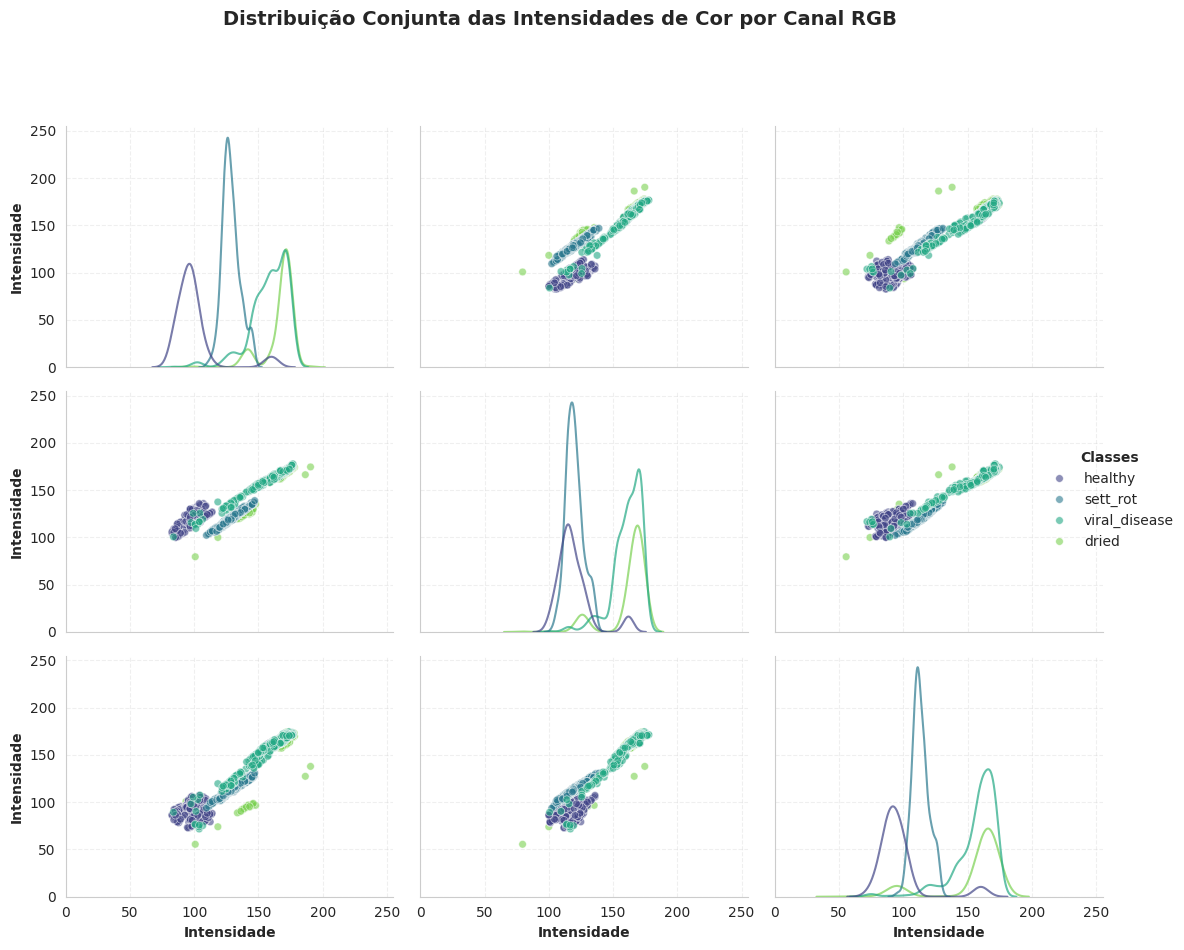

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = []
for cls in class_stats:
    means_rgb = np.array(class_stats[cls]['means_rgb'])

    for m in means_rgb:
        data.append({
            'Class': cls,
            'R': m[0],
            'G': m[1],
            'B': m[2],
            'Intensity': np.mean(m)  # Valor médio para ordenação
        })

df = pd.DataFrame(data)

# Ordena as classes pela intensidade média
class_order = df.groupby('Class')['Intensity'].mean().sort_values().index.tolist()
df['Class'] = pd.Categorical(df['Class'], categories=class_order, ordered=True)

sns.set_style("whitegrid")
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'

g = sns.pairplot(
    data=df,
    vars=['R', 'G', 'B'],
    hue='Class',
    palette='viridis',
    plot_kws={
        'alpha': 0.6,
        's': 30,
        'edgecolor': 'w',
        'linewidth': 0.5
    },
    diag_kws={
        'alpha': 0.7,
        'fill': False,
        'linewidth': 1.5
    },
    height=3,
    aspect=1.1,
    corner=False
)

g.fig.suptitle("Distribuição Conjunta das Intensidades de Cor por Canal RGB\n", y=1.05, fontsize=14, fontweight='bold')

for ax in g.axes.flat:
    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.grid(True, linestyle='--', alpha=0.3)
    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel('Intensidade', fontweight='bold')
    else:
        ax.set_ylabel('')

    if ax.get_subplotspec().is_last_row():
        ax.set_xlabel('Intensidade', fontweight='bold')
    else:
        ax.set_xlabel('')

legend = g._legend
legend.set_bbox_to_anchor((1.05, 0.5))
legend.set_title('Classes', prop={'weight':'bold'})

plt.tight_layout()
plt.show()

# Análise de Textura

In [68]:
from skimage.feature import graycomatrix, graycoprops

def calc_texture(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256)
    return graycoprops(glcm, 'contrast')[0,0], graycoprops(glcm, 'energy')[0,0]

for cls in class_stats:
    img = cv2.imread(class_stats[cls]['image_paths'][0])
    contrast, energy = calc_texture(img)
    print(f"{cls}: Contraste={contrast:.2f}, Energia={energy:.2f}")

dried: Contraste=0.96, Energia=0.09
healthy: Contraste=131.71, Energia=0.02
sett_rot: Contraste=82.85, Energia=0.02
viral_disease: Contraste=2.27, Energia=0.08


# Análise de Bordas

In [69]:
def analyze_edges(img_path):
    img = cv2.imread(img_path, 0)
    edges = cv2.Canny(img, 100, 200)
    edge_pixels = np.sum(edges > 0) / edges.size
    return edge_pixels

# Calcular para 50 imagens de cada classe
for cls in class_stats:
    edge_density = [analyze_edges(p) for p in class_stats[cls]['image_paths'][:100]]
    print(f"{cls}: Densidade média de bordas = {np.mean(edge_density):.2%}")

dried: Densidade média de bordas = 1.75%
healthy: Densidade média de bordas = 7.37%
sett_rot: Densidade média de bordas = 16.63%
viral_disease: Densidade média de bordas = 0.89%


# Análise de Contraste

<Axes: >

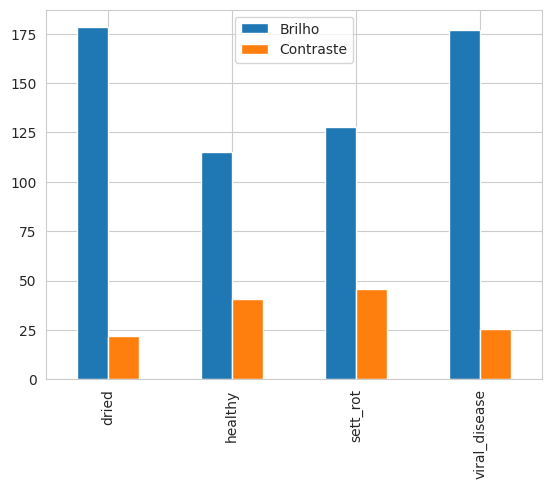

In [70]:
import pandas as pd

def calc_brightness_contrast(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    return np.mean(l), np.std(l)

results = {}
for cls in class_stats:
    img = cv2.imread(class_stats[cls]['image_paths'][0])
    brightness, contrast = calc_brightness_contrast(img)
    results[cls] = {'Brilho': brightness, 'Contraste': contrast}

pd.DataFrame(results).T.plot(kind='bar')

In [18]:
def plot_fourier_spectrum(img_path):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Erro: Não foi possível carregar a imagem {img_path}")
            return
        if img.size == 0:
            print(f"Erro: Imagem vazia {img_path}")
            return

        fft = np.fft.fft2(img)
        fft_shift = np.fft.fftshift(fft)
        magnitude_spectrum = 20 * np.log(np.abs(fft_shift) + 1e-10)  # Evita log(0)

        total_energy = np.sum(np.abs(fft)**2)

        # Cria máscara de baixa frequência (tipo uint8)
        low_freq_mask = np.zeros_like(img, dtype=np.uint8)
        center = (img.shape[1]//2, img.shape[0]//2)  # OpenCV usa (x,y)
        radius = min(center)//4
        cv2.circle(low_freq_mask, center, radius, 1, -1)

        # Converte para booleano após desenhar o círculo
        low_freq_mask = low_freq_mask.astype(bool)
        high_freq_energy = np.sum(np.abs(fft_shift[~low_freq_mask])**2)
        low_freq_energy = total_energy - high_freq_energy

        # Estatísticas
        print("\n" + "="*50)
        print(f"Análise de Fourier - {os.path.basename(img_path)}")
        print("="*50)
        print(f"- Dimensões: {img.shape} (HxW)")
        print(f"- Energia total do espectro: {total_energy:.2e}")
        print(f"- Energia em baixas frequências: {low_freq_energy:.2e} ({low_freq_energy/total_energy:.1%})")
        print(f"- Energia em altas frequências: {high_freq_energy:.2e} ({high_freq_energy/total_energy:.1%})")

        # Visualização
        plt.figure(figsize=(16, 8))

        # Imagem original + histograma
        plt.subplot(231)
        plt.imshow(img, cmap='gray')
        plt.title('Imagem Original'), plt.axis('off')

        plt.subplot(234)
        plt.hist(img.ravel(), bins=256, range=(0, 256))
        plt.title('Histograma de Intensidade')

        # Espectro de Fourier
        plt.subplot(232)
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Espectro de Fourier (log)'), plt.axis('off')

        # Mapa de frequências (baixa/alta)
        freq_map = np.zeros_like(magnitude_spectrum)
        freq_map[low_freq_mask] = 1
        plt.subplot(235)
        plt.imshow(freq_map, cmap='jet')
        plt.title('Distribuição de Frequências\n(azul=baixa, vermelho=alta)'), plt.axis('off')

        # Perfil radial
        y, x = np.indices(img.shape)
        r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
        r = r.astype(int)
        radial_profile = [magnitude_spectrum[r == i].mean() for i in range(0, max(center)+1)]

        plt.subplot(133)
        plt.plot(radial_profile)
        plt.title('Perfil Radial do Espectro')
        plt.xlabel('Distância do Centro (pixels)')
        plt.ylabel('Magnitude Média (dB)')
        plt.grid()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Erro ao processar {img_path}: {str(e)}")
        import traceback
        traceback.print_exc()

for class_name in class_stats:
    class_stats[class_name]['fourier_energy'] = []
    class_stats[class_name]['low_freq_ratio'] = []

    for img_path in class_stats[class_name]['image_paths']:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        fft = np.fft.fft2(img)
        fft_shift = np.fft.fftshift(fft)
        total_energy = np.sum(np.abs(fft)**2)

        # Máscara de baixa frequência
        low_freq_mask = np.zeros_like(img, dtype=np.uint8)
        center = (img.shape[1]//2, img.shape[0]//2)
        cv2.circle(low_freq_mask, center, min(center)//4, 1, -1)
        low_freq_mask = low_freq_mask.astype(bool)

        low_freq_energy = np.sum(np.abs(fft_shift[low_freq_mask])**2)
        low_freq_ratio = low_freq_energy / total_energy

        class_stats[class_name]['fourier_energy'].append(total_energy)
        class_stats[class_name]['low_freq_ratio'].append(low_freq_ratio)

for class_name in class_stats:
    if 'fourier_energy' in class_stats[class_name]:
        print(f"\nClasse: {class_name}")
        print(f"- Energia média do espectro: {np.mean(class_stats[class_name]['fourier_energy']):.2e}")
        print(f"- Proporção média em baixas frequências: {np.mean(class_stats[class_name]['low_freq_ratio']):.1%}")


Classe: dried
- Energia média do espectro: 1.72e+16
- Proporção média em baixas frequências: 99.8%

Classe: healthy
- Energia média do espectro: 8.64e+15
- Proporção média em baixas frequências: 99.2%

Classe: sett_rot
- Energia média do espectro: 1.07e+16
- Proporção média em baixas frequências: 98.5%

Classe: viral_disease
- Energia média do espectro: 1.48e+16
- Proporção média em baixas frequências: 99.9%


In [74]:
def quick_fourier_plot(img_path, class_name=""):
    """Versão que inclui o nome da classe no título"""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Erro ao carregar: {img_path}")
        return

    fft_shift = np.fft.fftshift(np.fft.fft2(img))
    spectrum = 20 * np.log(np.abs(fft_shift) + 1e-10)

    plt.figure(figsize=(10, 4))

    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title(f'Original - {class_name}\n{os.path.basename(img_path)}'), plt.axis('off')

    plt.subplot(122)
    plt.imshow(spectrum, cmap='jet')
    plt.title('Espectro de Fourier'), plt.axis('off')

    plt.tight_layout()
    plt.show()

num_imagens = 3

for class_name in class_stats:
    print(f"\n{'='*50}")
    print(f"ANÁLISE DA CLASSE: {class_name.upper()}")
    print(f"- Energia média do espectro: {np.mean(class_stats[class_name]['fourier_energy']):.2e}")
    print(f"- Proporção média em baixas frequências: {np.mean(class_stats[class_name]['low_freq_ratio']):.1%}")
    print(f"{'='*50}")

    for img_path in class_stats[class_name]['image_paths'][:num_imagens]:
        quick_fourier_plot(img_path, class_name)
        print(f"Imagem analisada: {os.path.basename(img_path)}")
        print("-"*60)


ANÁLISE DA CLASSE: DRIED


KeyError: 'fourier_energy'